<a href="https://colab.research.google.com/github/chihina/pytorch-tutorial/blob/master/1_6_what_is_torch_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Tutorial 1-6: WHAT IS TORCH.NN REALLY?**  

https://pytorch.org/tutorials/beginner/nn_tutorial.html

# Overview
This tutorial's object is to understand torch nn module. 

# MNIST data setup


## Download MNIST data

In [2]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

## Visualize MNIST data

(50000, 784)


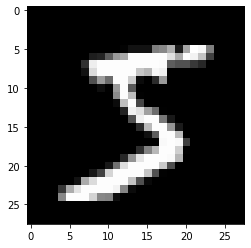

In [3]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

## Numpy array to Torch tensor

In [4]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
x_train, x_train.shape, y_train.min(), y_train.max()
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


# Neural net from scratch (no torch.nn)  

Let’s first create a model using nothing but PyTorch tensor operations. 

## Initialize weights and define functions

In [5]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

## forword path

In [6]:
bs = 64  # batch size

xb = x_train[0:bs]  # a mini-batch from x
preds = model(xb)  # predictions
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.5959, -2.2890, -1.8565, -2.0695, -2.1266, -2.1919, -2.4065, -3.0839,
        -2.2309, -2.6985], grad_fn=<SelectBackward>) torch.Size([64, 10])


## Define loss function and loss calculate

In [7]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.1984, grad_fn=<NegBackward>)


## Define accuracy function and accuracy calculate

In [8]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

print(accuracy(preds, yb))

tensor(0.1406)


## Train and check accuracy


In [9]:
lr = 0.5  # learning rate
epochs = 2  # how many epochs to train for

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0835, grad_fn=<NegBackward>) tensor(1.)


# Neural net from scratch (torch.nn)  

Let’s first create a model using torch nn modules.

## Replace loss function

In [10]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias
  
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0835, grad_fn=<NllLossBackward>) tensor(1.)


## Replace model

In [11]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.3055, grad_fn=<NllLossBackward>)


## Replace weights updating method

In [12]:
# with torch.no_grad():
#     weights -= weights.grad * lr
#     bias -= bias.grad * lr
#     weights.grad.zero_()
#     bias.grad.zero_()

def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()
print(loss_func(model(xb), yb))

tensor(0.0817, grad_fn=<NllLossBackward>)


## Replace network structure

In [13]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)
  
model = Mnist_Logistic()
fit()
print(loss_func(model(xb), yb))

tensor(0.0798, grad_fn=<NllLossBackward>)


## Replace optimize method

In [14]:
# with torch.no_grad():
    # for p in model.parameters(): p -= p.grad * lr
    # model.zero_grad()

from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.3515, grad_fn=<NllLossBackward>)
tensor(0.0812, grad_fn=<NllLossBackward>)


## Replace Dataset

In [15]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0805, grad_fn=<NllLossBackward>)


## Add validation


In [16]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.2967)
1 tensor(0.4526)


## Ingenuity loss function and get batch data 

In [17]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.40777898954153063
1 0.30664607434272767


## Switch to CNN

In [18]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.43019237008094785
1 0.26743931033611296


## nn.Sequential

In [19]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


def preprocess(x):
    return x.view(-1, 1, 28, 28)

model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.38413968963623046
1 0.3691746317625046


## Wrapping DataLoader

In [20]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.33815653438568116
1 0.27624753241539


## Using your GPU

In [21]:
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
fit(epochs, model, loss_func, opt, train_dl, valid_dl)


True
0 0.20343865908384323
1 0.1886150959968567
